## DATA MINING PROJECT
# ABCDEats Inc\. Final Report

**Group 20** <br>
Afonso Gamito, 20240752 <br>
Gonçalo Pacheco, 20240695 <br>
Hassan Bhatti, 20241023 <br>
Moeko Mitani, 20240670

# Import the Libraries and CVS file

In [1]:
## Libraries
import os  
import numpy as np
import pandas as pd  
from os.path import join  

# Visualization
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches  

# Clustering and metrics
from scipy.cluster.hierarchy import dendrogram 
from sklearn.cluster import AgglomerativeClustering, KMeans  
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances   

# Mathematical
from math import ceil  

# Model Manipulation
from itertools import product
from sklearn.base import clone  
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz


# Set Seaborn default theme for better plot aesthetics
sns.set()

# Suppress warnings for clearer outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import CVS file
file_path = 'project_data/preprocessed_dataset.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,customer_id,vendor_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,age_group,morning_orders,afternoon_orders,evening_orders,customer_frequency,customer_preference,weekend_orders
0,1b8f824d5e,0.076923,True,DIGI,0.011111,0.035654,City A,0.013514,Young Adult,0.000000,0.000000,0.066667,Infrequent,CUI_Indian,0.08
1,5d272b9dcb,0.076923,True,DIGI,0.011111,0.023561,City C,0.013514,Child,0.044444,0.000000,0.000000,Infrequent,CUI_American,0.08
2,f6d1b2ba63,0.000000,True,CASH,0.011111,0.011043,City B,0.013514,Adult,0.044444,0.000000,0.000000,Infrequent,CUI_American,0.08
3,180c632ed8,0.076923,True,DIGI,0.022222,0.039006,City B,0.013514,Young Adult,0.022222,0.027027,0.000000,Infrequent,CUI_Indian,0.04
4,4eb37a6705,0.076923,False,DIGI,0.022222,0.068869,City B,0.013514,Young Adult,0.044444,0.000000,0.000000,Infrequent,CUI_Asian,0.04


In [4]:
df.columns

Index(['customer_id', 'vendor_count', 'is_chain', 'payment_method',
       'days_as_customer', 'money_spent', 'customer_city', 'total_orders',
       'age_group', 'morning_orders', 'afternoon_orders', 'evening_orders',
       'customer_frequency', 'customer_preference', 'weekend_orders'],
      dtype='object')

In [5]:
# Splitting feature names into groups
metric_features = [
    'vendor_count',
    'days_as_customer',
    'money_spent',
    'total_orders',
    'morning_orders',
    'afternoon_orders',
    'evening_orders',
    'weekend_orders'
 ]

non_metric_features = [
    'is_chain',
    'payment_method',
    'customer_city',
    'age_group',
    'customer_frequency',
    'customer_preference',
]

unused_features = [i for i in df.columns if i not in (metric_features+non_metric_features) ]

In [6]:
print('metric_features:', metric_features)
print('non_metric_features:', non_metric_features)
print('unused_features:', unused_features)

metric_features: ['vendor_count', 'days_as_customer', 'money_spent', 'total_orders', 'morning_orders', 'afternoon_orders', 'evening_orders', 'weekend_orders']
non_metric_features: ['is_chain', 'payment_method', 'customer_city', 'age_group', 'customer_frequency', 'customer_preference']
unused_features: ['customer_id']


# 13. Hierarchical Clustering

## Defining the linkage method

In [7]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

array([4, 4, 4, ..., 4, 4, 4])

In [8]:
# Characterizing the clusters

labels_series = pd.Series(hc_labels, 
                          name='labels', 
                          index=df.index # WHY df.index ??
                          ) 

df_concat = pd.concat([df, labels_series],axis=1)

df_concat[metric_features+['labels']].groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,
0,0.147717,0.662741,0.045571,0.043433,0.025789,0.049649,0.024762,0.047375
1,0.814815,0.862039,0.178057,0.259971,0.127170,0.224313,0.160110,0.237992
2,0.387635,0.800983,0.098647,0.114234,0.058739,0.103376,0.068780,0.110884
3,0.119270,0.327451,0.035665,0.029379,0.019532,0.034000,0.020794,0.037564
4,0.032025,0.032537,0.022152,0.007277,0.009664,0.016104,0.009288,0.016610


In [9]:
# SSt

x_i = df_concat[metric_features]
x_mean = df_concat[metric_features].mean()

sst_sum = np.sum(np.sum(np.square(x_i - x_mean), axis=0), axis=0)
sst_sum

5355.039596278378

In [10]:
# SSb

ssb_sum = 0
x_mean = df_concat[metric_features].mean()

for i in df_concat['labels'].unique():
    df_k = df_concat.loc[df_concat['labels']==i, metric_features]
    n_k = df_k.shape[0]
    x_k = df_k.mean()
    ssb_sum += (n_k * np.square((x_k - x_mean)))

ssb_sum = ssb_sum.sum()
ssb_sum

4325.870054001923

In [11]:
# SSw

ssw_sum = 0

for i in df_concat['labels'].unique():
    df_k = df_concat.loc[df_concat['labels']==i, metric_features]
    x_k = df_k.mean()
    ssw_sum += (np.sum(np.square(df_k - x_k ), axis=0))


ssw_sum = np.sum(ssw_sum, axis=0)

ssw_sum

1029.169542276456

In [12]:
# Verify: 

sst_sum == ssw_sum + ssb_sum

False

In [23]:
############### MOEKO ###################
# Let's wrap them into functions

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb



def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats + [label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats))

    return df_k.sum()


In [25]:
############### MOEKO ###################
df_sst_ = get_ss(df_concat, metric_features)
df_ssb_ = get_ssb(df_concat, metric_features, 'labels')
df_ssw_ = get_ssw(df_concat, metric_features, 'labels')

print("SSb:  ", df_ssb_)
print("SSw:  ", df_ssw_)
print("SSt:  ", df_sst_)
print("SSt == SSb+SSw ? ", (df_sst_ == df_ssb_ + df_ssw_))


SSb:   4325.870054001923
SSw:   1029.1695422764458
SSt:   5355.0395962779185
SSt == SSb+SSw ?  False


In [21]:
# Let's wrap them into functions

def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]

    df_k = df[feats_label].groupby(by=label_col).apply(lambda col: get_ss(col, feats), 
                                                       include_groups=False)

    return df_k.sum()

In [24]:
df_sst_ = get_ss(df_concat, metric_features)
df_ssb_ = get_ssb(df_concat, metric_features, 'labels')
df_ssw_ = get_ssw(df_concat, metric_features, 'labels')

print("SSb:  ", df_ssb_)
print("SSw:  ", df_ssw_)
print("SSt:  ", df_sst_)
print("SSt == SSb+SSw ? ", (df_sst_ == df_ssb_ + df_ssw_))

SSb:   4325.870054001923
SSw:   1029.1695422764458
SSt:   5355.0395962779185
SSt == SSb+SSw ?  False


In [15]:
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)

In [16]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)  
        
        
        # append the R2 of the given cluster solution
        r2.append(get_rsq(df_concat, feats, 'labels'))
        
    return np.array(r2)

In [17]:
##########################################
# THIS TAKES A FEW MINUTES TO RUN!!
##########################################

hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([ get_r2_hc(df[metric_features], 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

In [18]:
r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)

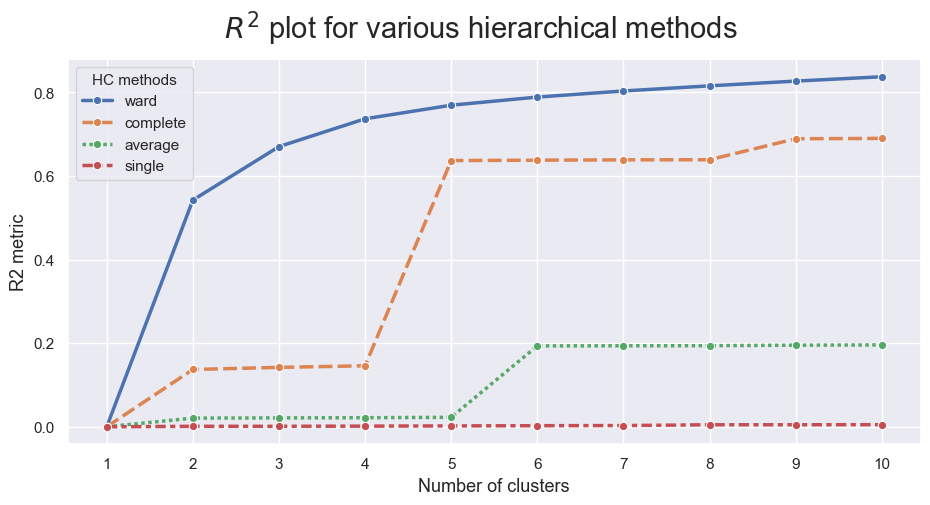

In [19]:
sns.set()

# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)

plt.show()

### Defining the number of clusters:

In [20]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'


hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([28271, 29318, 20177, ...,     6,     2,     0], dtype=int64)

In [21]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)



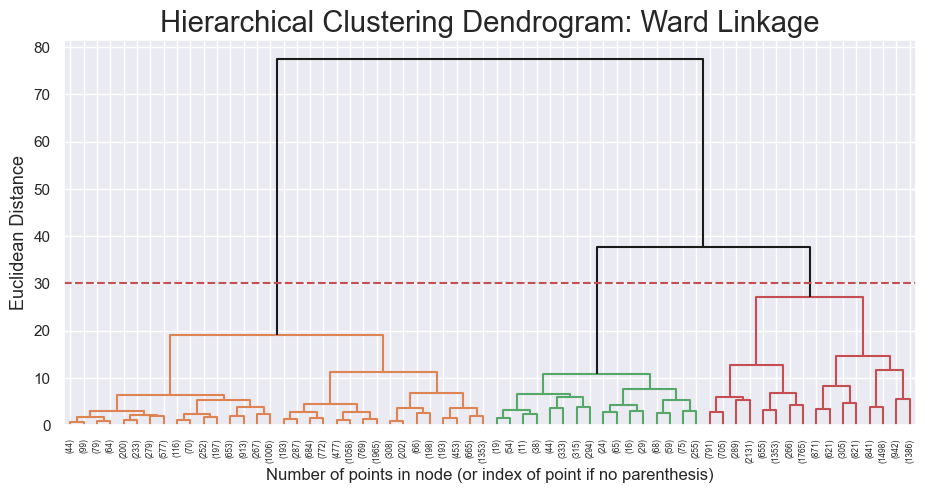

In [22]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Test cluster solutions

In [23]:
# 2 cluster solution
n_clusters = 2

hc2_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc2_labels = hc2_clust.fit_predict(df[metric_features])

In [24]:
# Characterizing the 2 clusters
df_concat = pd.concat([df[metric_features], 
                       pd.Series(hc2_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,average_purchase,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,,
0,0.253380,0.661338,0.066967,0.074854,0.085472,0.040833,0.073370,0.044704,0.075516
1,0.052635,0.088392,0.025508,0.012533,0.115917,0.011637,0.020233,0.012683,0.021987


In [25]:
# 3 cluster solution
n_clusters = 3

hc3_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc3_labels = hc3_clust.fit_predict(df[metric_features])

In [26]:
# Characterizing the 3 clusters
df_concat = pd.concat([df[metric_features], 
                       pd.Series(hc3_labels, 
                                 name='labels', 
                                 index=df.index)], 
                    axis=1)

df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,average_purchase,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,,
0,0.200040,0.637769,0.054668,0.055660,0.086723,0.031782,0.058518,0.032006,0.058496
1,0.052635,0.088392,0.025508,0.012533,0.115917,0.011637,0.020233,0.012683,0.021987
2,0.731833,0.872755,0.177296,0.247029,0.074247,0.122019,0.206592,0.158603,0.228181


In [27]:
## See crosstab of 2 vs 3
## What does this mean?

pd.crosstab(
    pd.Series(hc3_labels, name='hc3_labels', index=df.index),
    pd.Series(hc2_labels, name='hc2_labels', index=df.index),
    )

hc2_labels,0,1
hc3_labels,,
0,15240,0
1,0,14692
2,1699,0


### Final Hierarchical clustering solution

In [28]:
# final cluster solution
linkage = "ward"
distance = "euclidean"
n_clusters = 3

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(df[metric_features])

In [29]:
# Characterizing the final clusters

df_concat = pd.concat([
    df[metric_features], 
    pd.Series(hc_labels, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,average_purchase,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,,
0,0.200040,0.637769,0.054668,0.055660,0.086723,0.031782,0.058518,0.032006,0.058496
1,0.052635,0.088392,0.025508,0.012533,0.115917,0.011637,0.020233,0.012683,0.021987
2,0.731833,0.872755,0.177296,0.247029,0.074247,0.122019,0.206592,0.158603,0.228181


## Visualize the cluster means as a heatmap

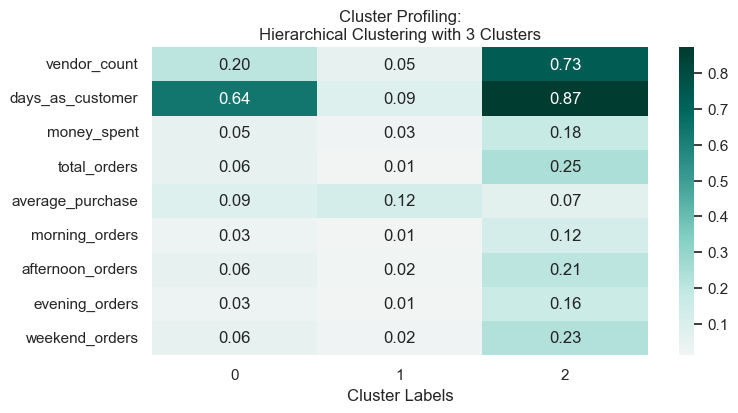

In [30]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

## Compare the cluster means to the population means. 

In [31]:
hc_profile = df_concat.groupby('labels').mean().T

df_means = df_concat[metric_features].mean()
df_means.name="Data"


pd.concat([hc_profile, 
           df_means], axis=1
)

,0,1,2,Data
vendor_count,0.200040,0.052635,0.731833,0.160137
days_as_customer,0.637769,0.088392,0.872755,0.395216
money_spent,0.054668,0.025508,0.177296,0.047710
total_orders,0.055660,0.012533,0.247029,0.045907
average_purchase,0.086723,0.115917,0.074247,0.099613
morning_orders,0.031782,0.011637,0.122019,0.027272
afternoon_orders,0.058518,0.020233,0.206592,0.048689
evening_orders,0.032006,0.012683,0.158603,0.029830
weekend_orders,0.058496,0.021987,0.228181,0.050653


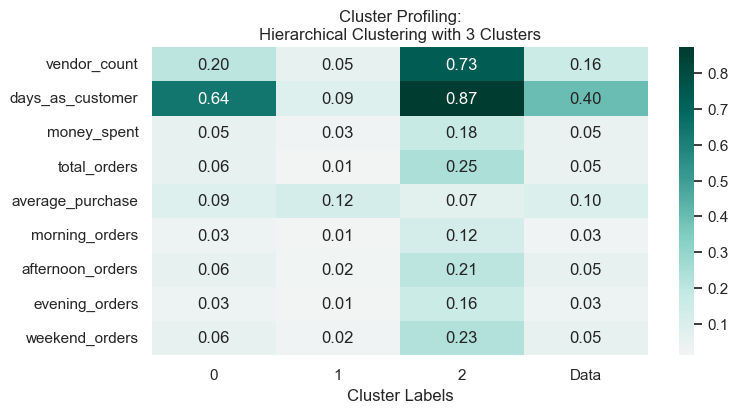

In [32]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

df_means = df_concat[metric_features].mean()
df_means.name="Data"


hc_profile = pd.concat([hc_profile, 
                        df_means], axis=1
                        )

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

## Visualize the cluster means with the cluster sizes

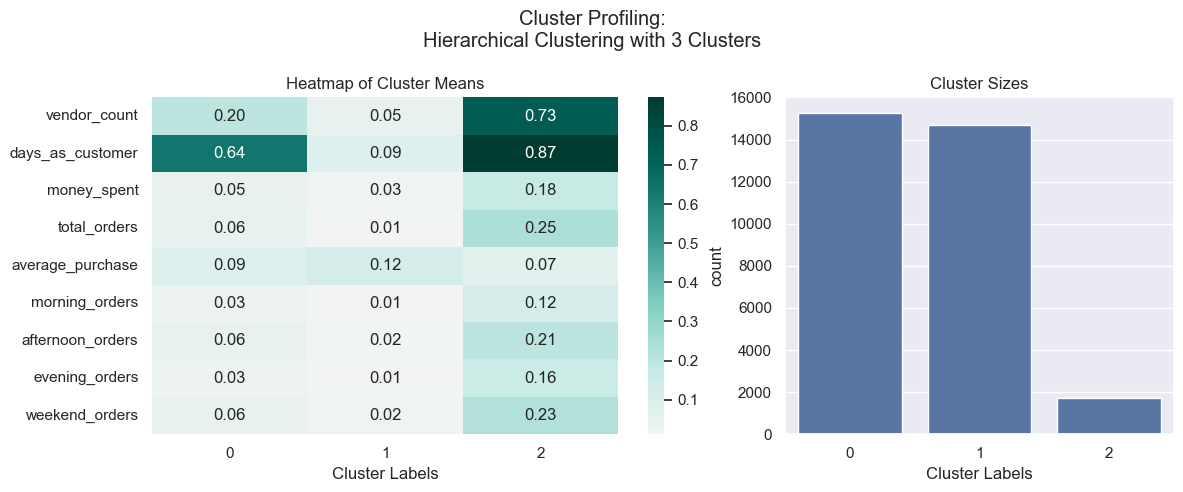

In [33]:
label_counts = None 

fig, axes = plt.subplots(1,2, figsize=(12,5), width_ratios=[.6,.4], tight_layout=True)

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=axes[0]
            )
axes[0].set_xlabel("Cluster Labels")
axes[0].set_title("Heatmap of Cluster Means")


sns.countplot(df_concat, x='labels', ax=axes[1])
axes[1].set_title("Cluster Sizes")
axes[1].set_xlabel("Cluster Labels")

fig.suptitle("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()

# 14. K-Means Clustering

In [34]:
kmclust = KMeans(n_clusters=8, init='random', n_init=10, random_state=1)

In [35]:
# The fit method
kmclust.fit(df[metric_features])

KMeans(init='random', n_init=10, random_state=1)

In [36]:
# The predict method
kmclust.predict(df[metric_features])

array([7, 7, 7, ..., 2, 2, 7])

In [37]:
# The transform method
pd.DataFrame(kmclust.transform(df[metric_features]))

,0,1,2,3,4,5,6,7
0,0.591773,0.287385,0.158773,0.549494,0.818760,0.943770,1.286055,0.121135
1,0.589706,0.280288,0.188962,0.546042,0.816723,0.943926,1.289200,0.092557
2,0.626589,0.304047,0.225758,0.556827,0.831289,0.981827,1.339659,0.090111
3,0.581858,0.270574,0.121930,0.535123,0.806465,0.936353,1.286171,0.100139
4,0.609376,0.325878,0.087506,0.564870,0.826947,0.953839,1.298684,0.216863
...,...,...,...,...,...,...,...,...
31626,0.644825,0.319033,0.245147,0.570960,0.847190,1.002357,1.366968,0.083646
31627,0.644019,0.317488,0.242405,0.569834,0.846097,1.001374,1.366276,0.079425
31628,0.654174,0.337323,0.040599,0.580360,0.853798,1.007631,1.370374,0.161754
31629,0.651834,0.332778,0.048541,0.577771,0.852010,1.006130,1.369297,0.150834


In [38]:
# Different initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [39]:
kmclust.predict(df[metric_features])

array([4, 4, 4, ..., 0, 0, 4])

## Defining the number of clusters

In [40]:
range_clusters = range(1, 11)

In [41]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

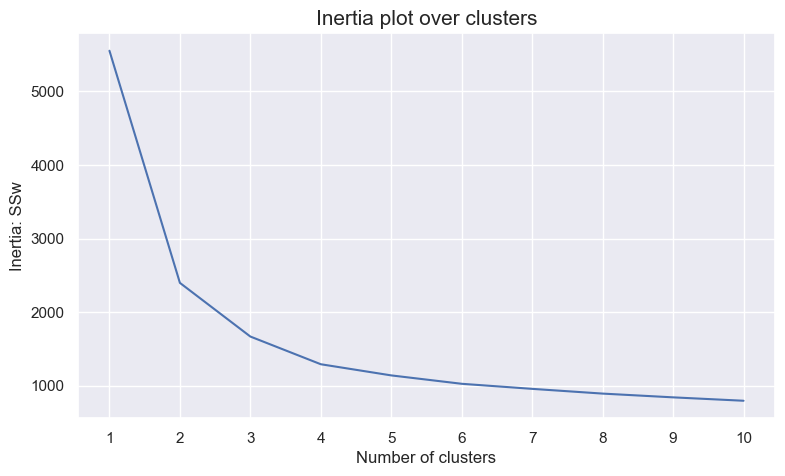

In [42]:
# The inertia plot

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5025942699558676
For n_clusters = 3, the average silhouette_score is : 0.46891138406489835
For n_clusters = 4, the average silhouette_score is : 0.40303068037996326
For n_clusters = 5, the average silhouette_score is : 0.37488035179753953
For n_clusters = 6, the average silhouette_score is : 0.3290344260201164
For n_clusters = 7, the average silhouette_score is : 0.285696267131346
For n_clusters = 8, the average silhouette_score is : 0.2861664855011125
For n_clusters = 9, the average silhouette_score is : 0.2820142636799218
For n_clusters = 10, the average silhouette_score is : 0.2802834301599378


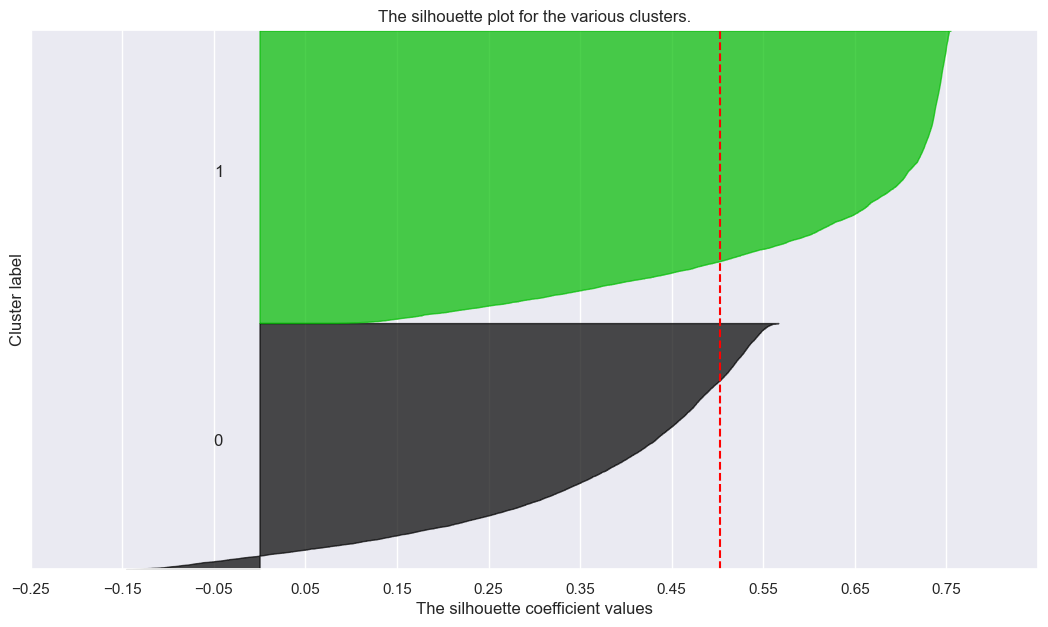

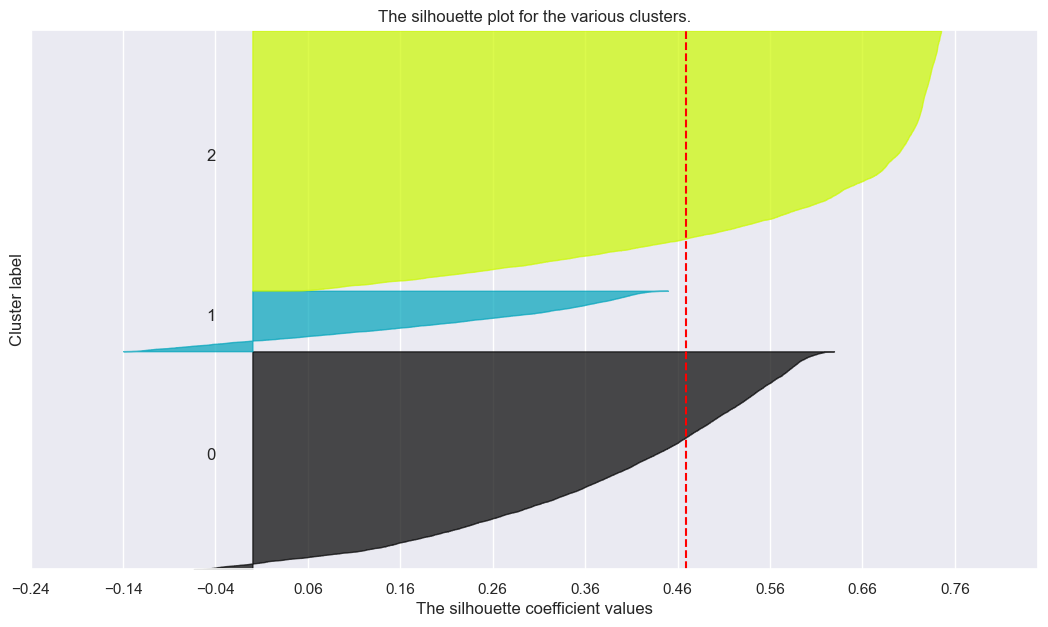

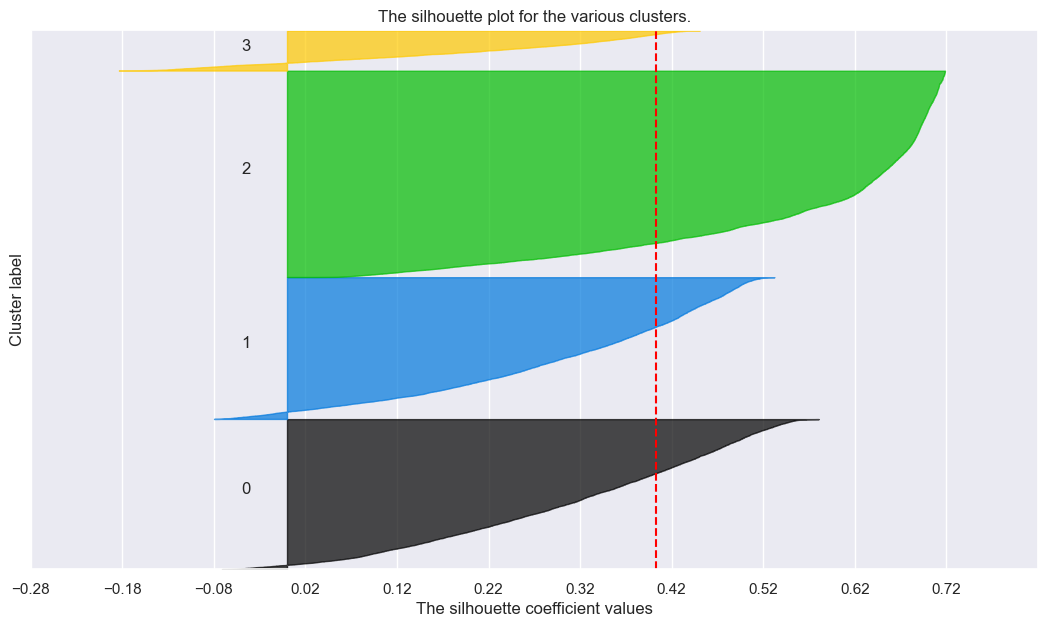

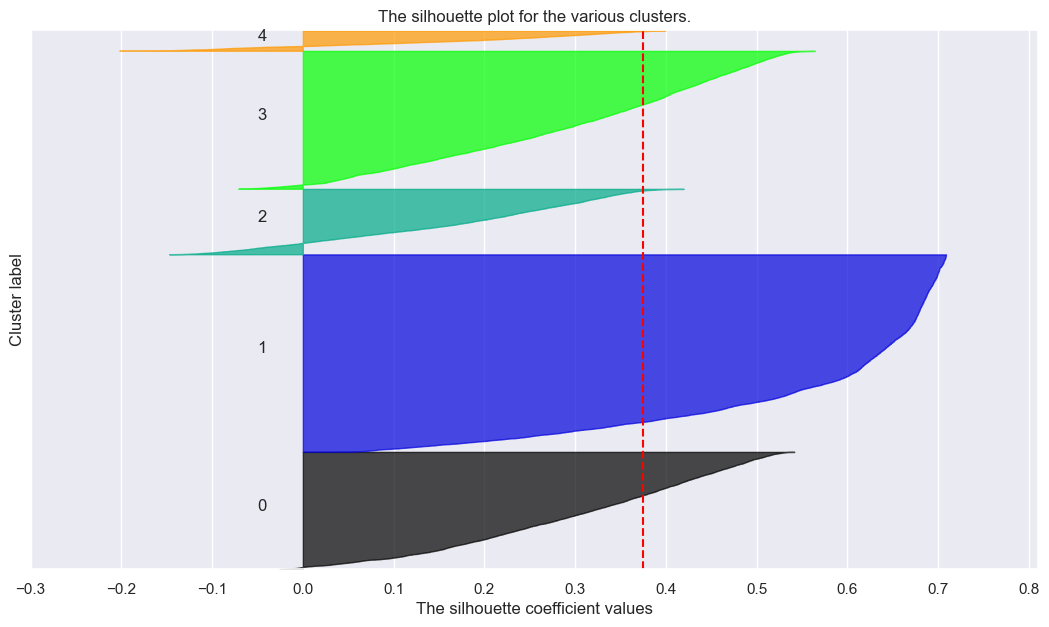

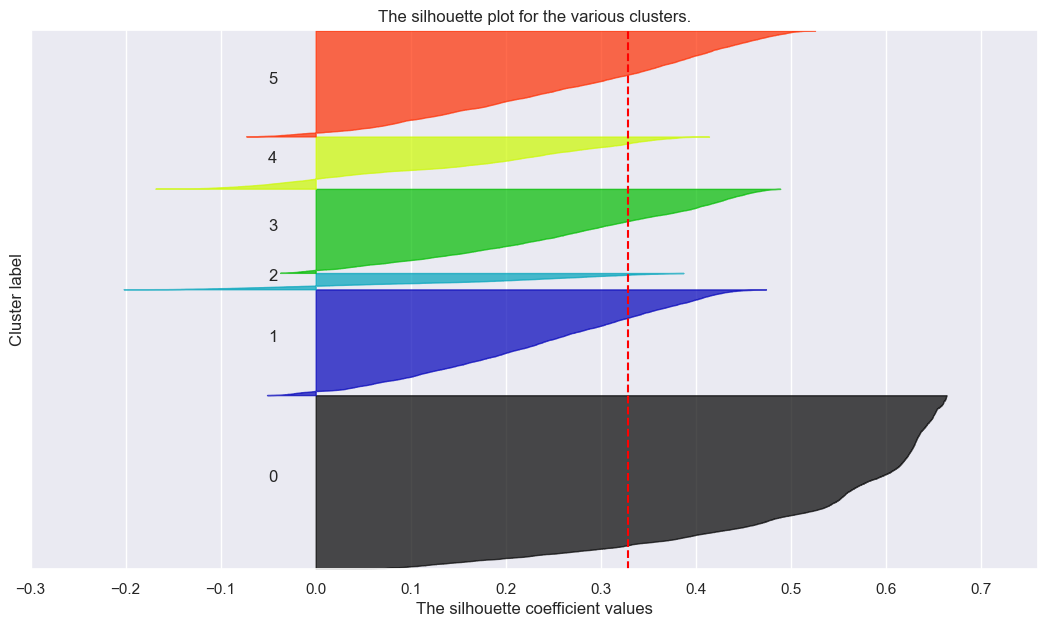

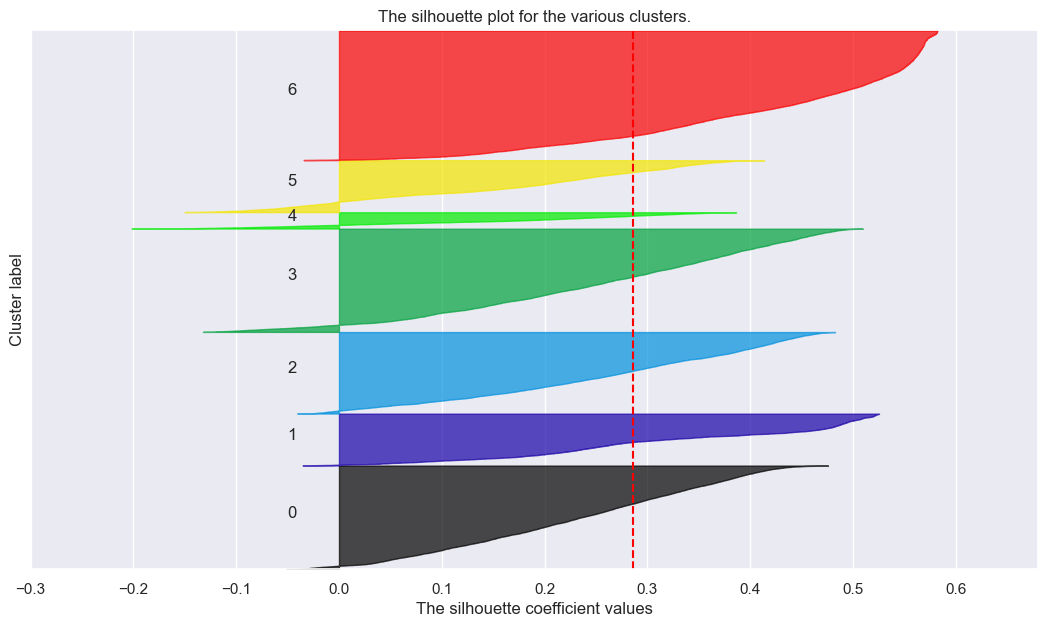

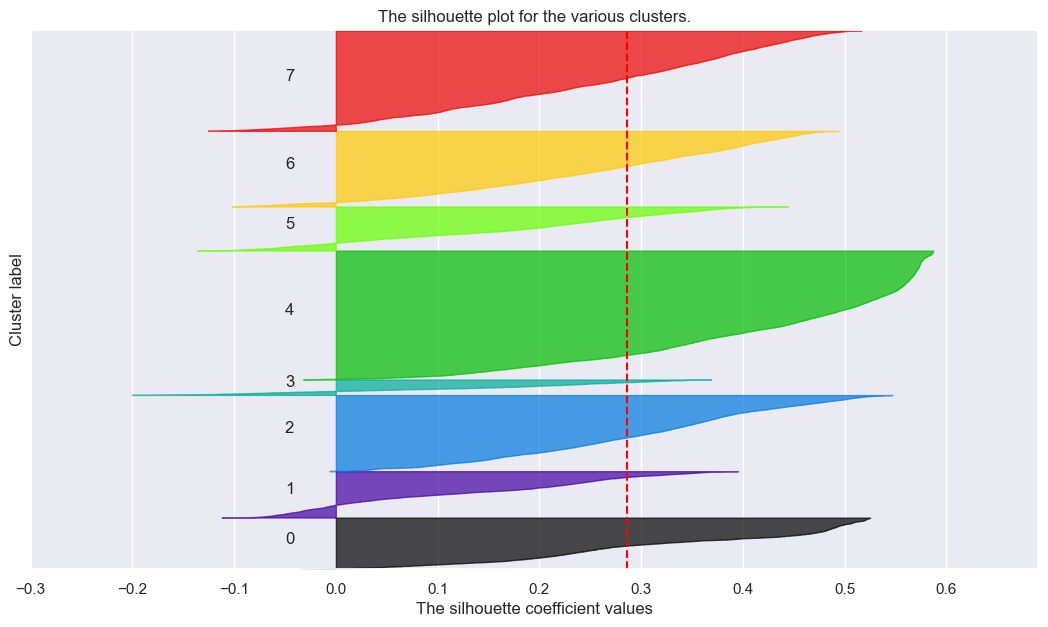

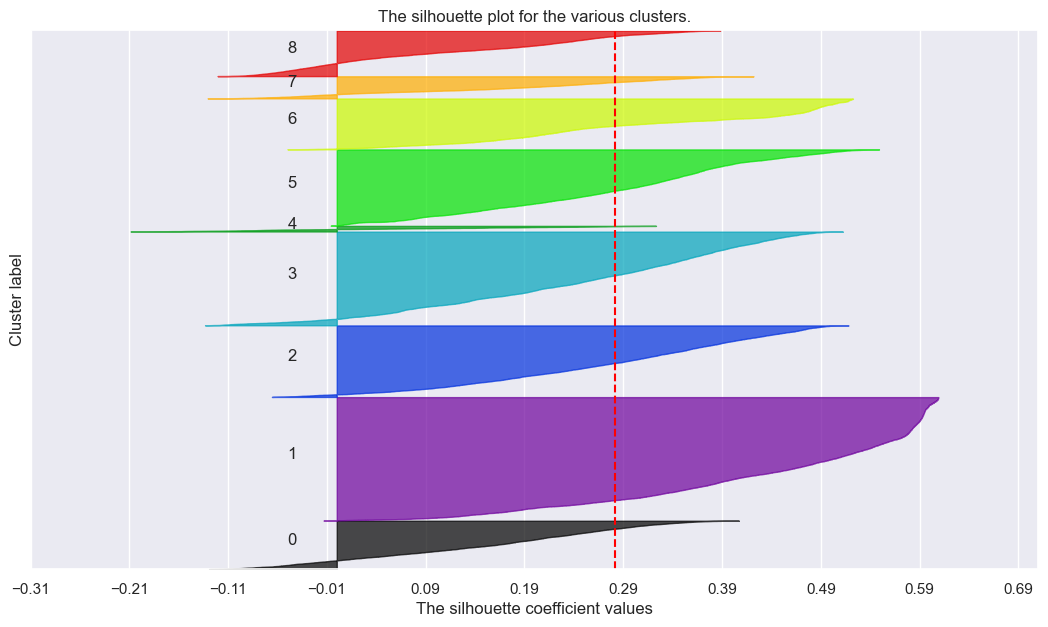

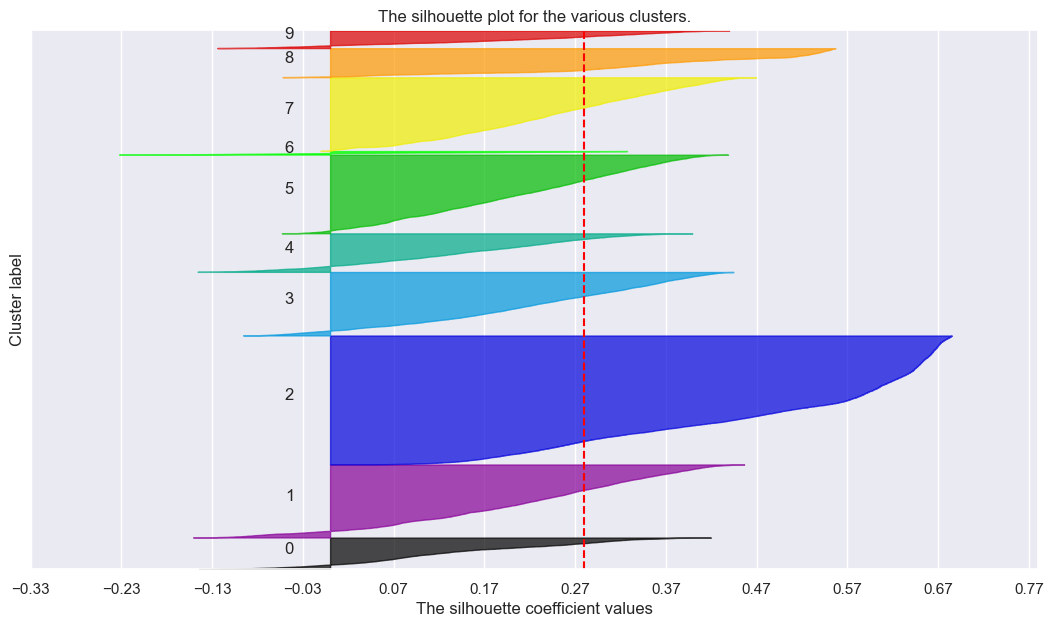

In [43]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

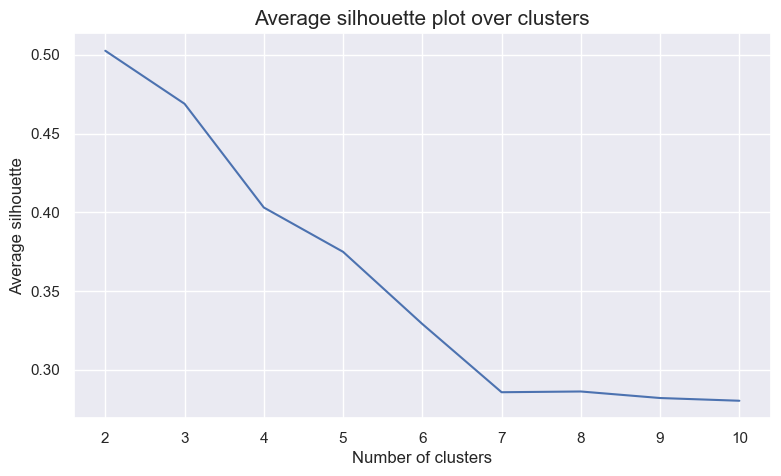

In [44]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range_clusters[1:], ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

## Final KMeans clustering solution

In [45]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[metric_features])
km_labels

array([2, 2, 2, ..., 2, 2, 2])

In [46]:
# Characterizing the final clusters
df_concat = pd.concat((df[metric_features], pd.Series(km_labels, name='labels', index=df.index)), axis=1)
df_concat.groupby('labels').mean()

,vendor_count,days_as_customer,money_spent,total_orders,average_purchase,morning_orders,afternoon_orders,evening_orders,weekend_orders
labels,,,,,,,,,
0,0.171168,0.628279,0.049309,0.047736,0.087843,0.027615,0.051308,0.028990,0.052181
1,0.588350,0.839319,0.138823,0.183237,0.077549,0.093464,0.160069,0.108289,0.169440
2,0.051430,0.096981,0.025206,0.012475,0.114590,0.011608,0.020623,0.012308,0.021779


# 14. Clustering by perspectives

In [47]:
# Customer Behavior Perspective
behavior_features = [
    'morning_orders',
    'afternoon_orders',
    'evening_orders',
    'weekend_orders',
    'vendor_count'
]

# Customer Value Perspective
value_features = [
    'total_orders',
    'days_as_customer',
    'money_spent'
]

df_behavior = df[behavior_features].copy()
df_value = df[value_features].copy()

## Testing on K-means clustering and Hierarchical clustering
Based on the elbow method, the optimal number of clusters is between 2 and 3.

In [48]:
# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    metric='euclidean'
)

In [49]:
def get_r2_scores(df, feats, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        df_concat = pd.concat([df, 
                               pd.Series(labels, name='labels', index=df.index)], axis=1)  

        r2_clust[n] = get_rsq(df_concat, feats, 'labels' )
    return r2_clust

### Finding the optimal clusterer on behavior variables

In [50]:
df_behavior[behavior_features]

,morning_orders,afternoon_orders,evening_orders,weekend_orders,vendor_count
0,0.000000,0.000000,0.066667,0.08,0.076923
1,0.044444,0.000000,0.000000,0.08,0.076923
2,0.044444,0.000000,0.000000,0.08,0.000000
3,0.022222,0.027027,0.000000,0.04,0.076923
4,0.044444,0.000000,0.000000,0.04,0.076923
...,...,...,...,...,...
31626,0.000000,0.000000,0.033333,0.00,0.000000
31627,0.000000,0.027027,0.000000,0.00,0.000000
31628,0.000000,0.027027,0.000000,0.00,0.000000
31629,0.000000,0.027027,0.000000,0.00,0.000000


In [51]:
# Obtaining the R² scores for each cluster solution on demographic variables
# This may take some time to run

r2_scores = {}

r2_scores['kmeans'] = get_r2_scores(df_behavior, behavior_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_behavior,                 # data
        behavior_features,   # features of perspective
        # use HClust, changing the linkage at each iteration
        hierarchical.set_params(linkage=linkage) 
    )

In [52]:
r2_scores_behavior = pd.DataFrame(r2_scores)
r2_scores_behavior

,kmeans,complete,average,single,ward
2,0.537319,0.037033,0.046938,0.000911,0.475172
3,0.683328,0.115709,0.047639,0.002105,0.651668
4,0.741232,0.118764,0.050863,0.003588,0.715524
5,0.768030,0.121526,0.054285,0.005096,0.751490
6,0.784785,0.127147,0.056367,0.005796,0.766385
7,0.800415,0.441878,0.056626,0.006699,0.780514
8,0.813375,0.445888,0.065101,0.007309,0.791245
9,0.822405,0.446687,0.485663,0.009344,0.801753


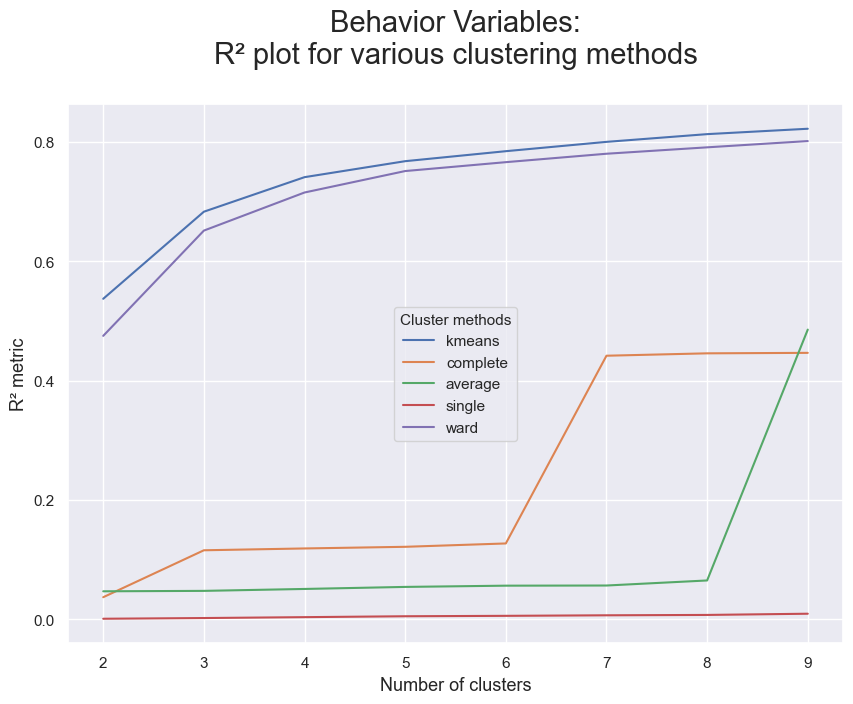

In [53]:
# Visualizing the R² scores for each cluster solution on behavior variables
r2_scores_behavior.plot.line(figsize=(10,7))

plt.title("Behavior Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Repeat the process for value variables

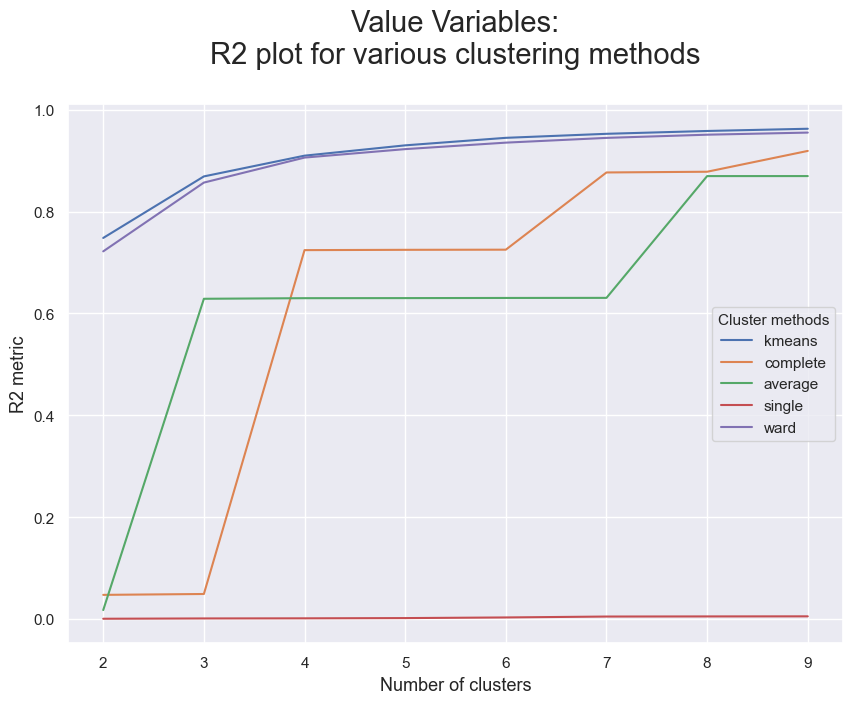

In [54]:
# Obtaining the R² scores for each cluster solution on value variables
r2_scores_value = {}
r2_scores_value['kmeans'] = get_r2_scores(df_value, value_features, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores_value[linkage] = get_r2_scores(
        df_value, value_features, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on value variables
pd.DataFrame(r2_scores_value).plot.line(figsize=(10,7))

plt.title("Value Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

## Merging the Perspectives
- How can we merge different cluster solutions?

In [55]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_value = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans_value.fit_predict(df_value)

kmeans_behavior = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behavior.fit_predict(df_behavior)

df['value_labels'] = value_labels
df['behavior_labels'] = behavior_labels

In [56]:
# Count label frequencies (contigency table)

pd.crosstab(df['behavior_labels'],
            df['value_labels'])

value_labels,0,1,2
behavior_labels,,,
0,4445,1315,4072
1,4309,11439,1687
2,43,4,1004
3,645,40,2628


### Manual merging: Merge lowest frequency clusters into closest clusters

In [57]:
# # Get centroids of clusters
# df_centroids = df.groupby(['behavior_labels', 'value_labels'])\
#     [metric_features].mean()


# df_centroids

In [58]:
# Clusters with low frequency to be merged:
# (behavior_label, value_label)
# to_merge = [(1,0), (1,1), (3,0), (3,1)]

In [59]:
# # Computing the euclidean distance matrix between the centroids
# centroid_dists = euclidean = pairwise_distances(df_centroids)

# df_dists = pd.DataFrame(
#     centroid_dists, 
#     columns=df_centroids.index, 
#     index=df_centroids.index
# )

# df_dists

In [60]:
# Merging each low frequency clustering (source) 
# to the closest cluster (target)

# source_target = {}

# for clus in to_merge:
#     # If cluster to merge (source) has not yet been used as target
#     if clus not in source_target.values():
#         # Add this cluster to source_target map as key
#         # Use the cluster with the smallest distance to it as value
#         source_target[clus] = df_dists.loc[clus].sort_values().index[1]

# source_target

In [61]:
#df_ = df.copy()

# # Changing the behavior_labels and product_labels based on source_target
# for source, target in source_target.items():
#     mask = (df_['behavior_labels']==source[0]) & (df_['value_labels']==source[1])
#     df_.loc[mask, 'behavior_labels'] = target[0]
#     df_.loc[mask, 'value_labels'] = target[1]

In [62]:
# to_merge

In [63]:
# New contigency table

# pd.crosstab(df_['behavior_labels'],
#             df_['value_labels'])

In [64]:
# # Get centroids of clusters
# df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
#     [metric_features].mean()


# df_centroids

In [65]:
# to_merge = [(3,1), (3,2), (2,1), (0,2)]

In [66]:
# # Computing the euclidean distance matrix between the centroids
# centroid_dists = euclidean = pairwise_distances(df_centroids)

# df_dists = pd.DataFrame(
#     centroid_dists, 
#     columns=df_centroids.index, 
#     index=df_centroids.index
# )

# df_dists

### Merging using Hierarchical clustering

In [57]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'value_labels'])\
    [metric_features].mean()
df_centroids

vendor_count  days_as_customer  money_spent  \
behavior_labels value_labels                                                
0               0                 0.196470          0.458715     0.046811   
                1                 0.175958          0.147714     0.040719   
                2                 0.216677          0.787756     0.062582   
1               0                 0.061642          0.426712     0.030781   
                1                 0.024854          0.045059     0.021308   
                2                 0.060736          0.773681     0.040041   
2               0                 0.817531          0.480620     0.131140   
                1                 0.884615          0.119444     0.109882   
                2                 0.856727          0.882061     0.194290   
3               0                 0.443172          0.489681     0.085493   
                1                 0.425000          0.173611     0.074777   
                2                 0.465841          0.826192     0.110148   

                              total_orders  average_purchase  morning_orders  \
behavior_labels value_labels                                                   
0               0                 0.044751          0.085866        0.026662   
                1                 0.034806          0.089903        0.023033   
                2                 0.063618          0.087145        0.034638   
1               0                 0.022451          0.093649        0.015064   
                1                 0.006626          0.122470        0.008864   
                2                 0.036207          0.089657        0.021761   
2               0                 0.186361          0.067833        0.093540   
                1                 0.192568          0.053417        0.155556   
                2                 0.286974          0.069213        0.146835   
3               0                 0.099246          0.081120        0.054229   
                1                 0.089865          0.077042        0.045000   
                2                 0.133263          0.080808        0.068848   

                              afternoon_orders  evening_orders  weekend_orders  
behavior_labels value_labels                                                    
0               0                     0.045384        0.029246        0.050547  
                1                     0.034570        0.023777        0.040395  
                2                     0.065663        0.036583        0.064322  
1               0                     0.031932        0.016315        0.030541  
                1                     0.016270        0.009374        0.016813  
                2                     0.049680        0.017941        0.041423  
2               0                     0.144563        0.143411        0.178605  
                1                     0.189189        0.041667        0.180000  
                2                     0.236352        0.181042        0.266414  
3               0                     0.081710        0.063876        0.100093  
                1                     0.089189        0.057500        0.092000  
                2                     0.120799        0.073795        0.123501

In [58]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

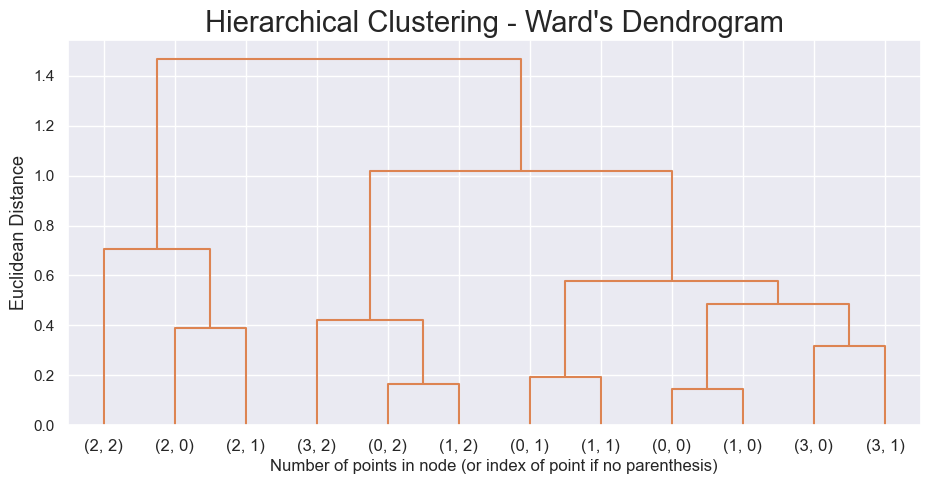

In [59]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 2.3
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [60]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

vendor_count  days_as_customer  money_spent  \
behavior_labels value_labels                                                
0               0                 0.196470          0.458715     0.046811   
                1                 0.175958          0.147714     0.040719   
                2                 0.216677          0.787756     0.062582   
1               0                 0.061642          0.426712     0.030781   
                1                 0.024854          0.045059     0.021308   
                2                 0.060736          0.773681     0.040041   
2               0                 0.817531          0.480620     0.131140   
                1                 0.884615          0.119444     0.109882   
                2                 0.856727          0.882061     0.194290   
3               0                 0.443172          0.489681     0.085493   
                1                 0.425000          0.173611     0.074777   
                2                 0.465841          0.826192     0.110148   

                              total_orders  average_purchase  morning_orders  \
behavior_labels value_labels                                                   
0               0                 0.044751          0.085866        0.026662   
                1                 0.034806          0.089903        0.023033   
                2                 0.063618          0.087145        0.034638   
1               0                 0.022451          0.093649        0.015064   
                1                 0.006626          0.122470        0.008864   
                2                 0.036207          0.089657        0.021761   
2               0                 0.186361          0.067833        0.093540   
                1                 0.192568          0.053417        0.155556   
                2                 0.286974          0.069213        0.146835   
3               0                 0.099246          0.081120        0.054229   
                1                 0.089865          0.077042        0.045000   
                2                 0.133263          0.080808        0.068848   

                              afternoon_orders  evening_orders  \
behavior_labels value_labels                                     
0               0                     0.045384        0.029246   
                1                     0.034570        0.023777   
                2                     0.065663        0.036583   
1               0                     0.031932        0.016315   
                1                     0.016270        0.009374   
                2                     0.049680        0.017941   
2               0                     0.144563        0.143411   
                1                     0.189189        0.041667   
                2                     0.236352        0.181042   
3               0                     0.081710        0.063876   
                1                     0.089189        0.057500   
                2                     0.120799        0.073795   

                              weekend_orders  hclust_labels  
behavior_labels value_labels                                 
0               0                   0.050547              5  
                1                   0.040395              1  
                2                   0.064322              4  
1               0                   0.030541              5  
                1                   0.016813              1  
                2                   0.041423              4  
2               0                   0.178605              0  
                1                   0.180000              0  
                2                   0.266414              3  
3               0                   0.100093              2  
                1                   0.092000              2  
                2                   0.123501              6

In [61]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 5,
 (0, 1): 1,
 (0, 2): 4,
 (1, 0): 5,
 (1, 1): 1,
 (1, 2): 4,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 3,
 (3, 0): 2,
 (3, 1): 2,
 (3, 2): 6}

In [62]:
df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['value_labels'])
    ], axis=1
)

df_ 

,customer_id,customer_age,vendor_count,product_count,is_chain,payment_method,days_as_customer,money_spent,customer_city,total_orders,...,evening_orders,night_orders,customer_frequency,customer_preference,order_frequency,weekend_orders,week_orders,value_labels,behavior_labels,merged_labels
0,1b8f824d5e,0.081081,0.076923,0.147059,True,DIGI,0.011111,0.035654,City A,0.013514,...,0.066667,0.0,Infrequent,CUI_Indian,0.014085,0.08,0.00,1,1,1
1,5d272b9dcb,0.054054,0.076923,0.058824,True,DIGI,0.011111,0.023561,City C,0.013514,...,0.000000,0.0,Infrequent,CUI_American,0.014085,0.08,0.00,1,1,1
2,f6d1b2ba63,0.621622,0.000000,0.058824,True,CASH,0.011111,0.011043,City B,0.013514,...,0.000000,0.0,Infrequent,CUI_American,0.014085,0.08,0.00,1,1,1
3,180c632ed8,0.297297,0.076923,0.088235,True,DIGI,0.022222,0.039006,City B,0.013514,...,0.000000,0.0,Infrequent,CUI_Indian,0.014085,0.04,0.02,1,1,1
4,4eb37a6705,0.135135,0.076923,0.147059,False,DIGI,0.022222,0.068869,City B,0.013514,...,0.000000,0.0,Infrequent,CUI_Asian,0.014085,0.04,0.02,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31626,eb13c834e7,1.000000,0.000000,0.029412,True,CARD,0.000000,0.001726,City A,0.000000,...,0.033333,0.0,Infrequent,CUI_Chicken Dishes,0.000000,0.00,0.02,1,1,1
31627,f7be3a1a84,0.297297,0.000000,0.029412,True,CASH,0.000000,0.001863,City A,0.000000,...,0.000000,0.0,Infrequent,CUI_Italian,0.000000,0.00,0.02,1,1,1
31628,fc924e1758,0.135135,0.000000,0.058824,False,CASH,0.000000,0.028488,City B,0.000000,...,0.000000,0.0,Infrequent,CUI_OTHER,0.000000,0.00,0.02,1,1,1
31629,fcdbf7468b,0.189189,0.000000,0.088235,True,CARD,0.000000,0.027063,City B,0.000000,...,0.000000,0.0,Infrequent,CUI_OTHER,0.000000,0.00,0.02,1,1,1


In [63]:
# Merged cluster centroids
df_.groupby('merged_labels').mean(numeric_only=True)[metric_features]

,vendor_count,days_as_customer,money_spent,total_orders,average_purchase,morning_orders,afternoon_orders,evening_orders,weekend_orders
merged_labels,,,,,,,,,
0,0.823241,0.449882,0.129331,0.186889,0.066606,0.098818,0.148361,0.134752,0.178723
1,0.040434,0.055644,0.023309,0.009532,0.119112,0.010325,0.018156,0.010859,0.019244
2,0.442111,0.471225,0.084867,0.098698,0.080882,0.053690,0.082146,0.063504,0.099620
3,0.856727,0.882061,0.194290,0.286974,0.069213,0.146835,0.236352,0.181042,0.266414
4,0.170997,0.783633,0.055979,0.055589,0.087881,0.030866,0.060981,0.031122,0.057614
5,0.130103,0.442962,0.038920,0.033775,0.089697,0.020953,0.038762,0.022881,0.040699
6,0.465841,0.826192,0.110148,0.133263,0.080808,0.068848,0.120799,0.073795,0.123501


In [64]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

,0
merged_labels,
0,47
1,12754
2,685
3,1004
4,5759
5,8754
6,2628


In [65]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts

,merged_labels,0
0,"(2, 1)",47
1,"(1, 1)",12754
2,"(3, 1)",685
3,"(2, 2)",1004
4,"(1, 2)",5759
5,"(1, 0)",8754
6,"(3, 2)",2628


In [66]:
df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['value_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

,merged_labels,0,behavior_labels,value_labels
0,"(2, 1)",47,2,1
1,"(1, 1)",12754,1,1
2,"(3, 1)",685,3,1
3,"(2, 2)",1004,2,2
4,"(1, 2)",5759,1,2
5,"(1, 0)",8754,1,0
6,"(3, 2)",2628,3,2


In [67]:
df_counts.pivot(values=0, index='behavior_labels', columns='value_labels')

value_labels,0,1,2
behavior_labels,,,
1,8754.0,12754.0,5759.0
2,NaN,47.0,1004.0
3,NaN,685.0,2628.0


In [68]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

## Cluster Analysis

In [69]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

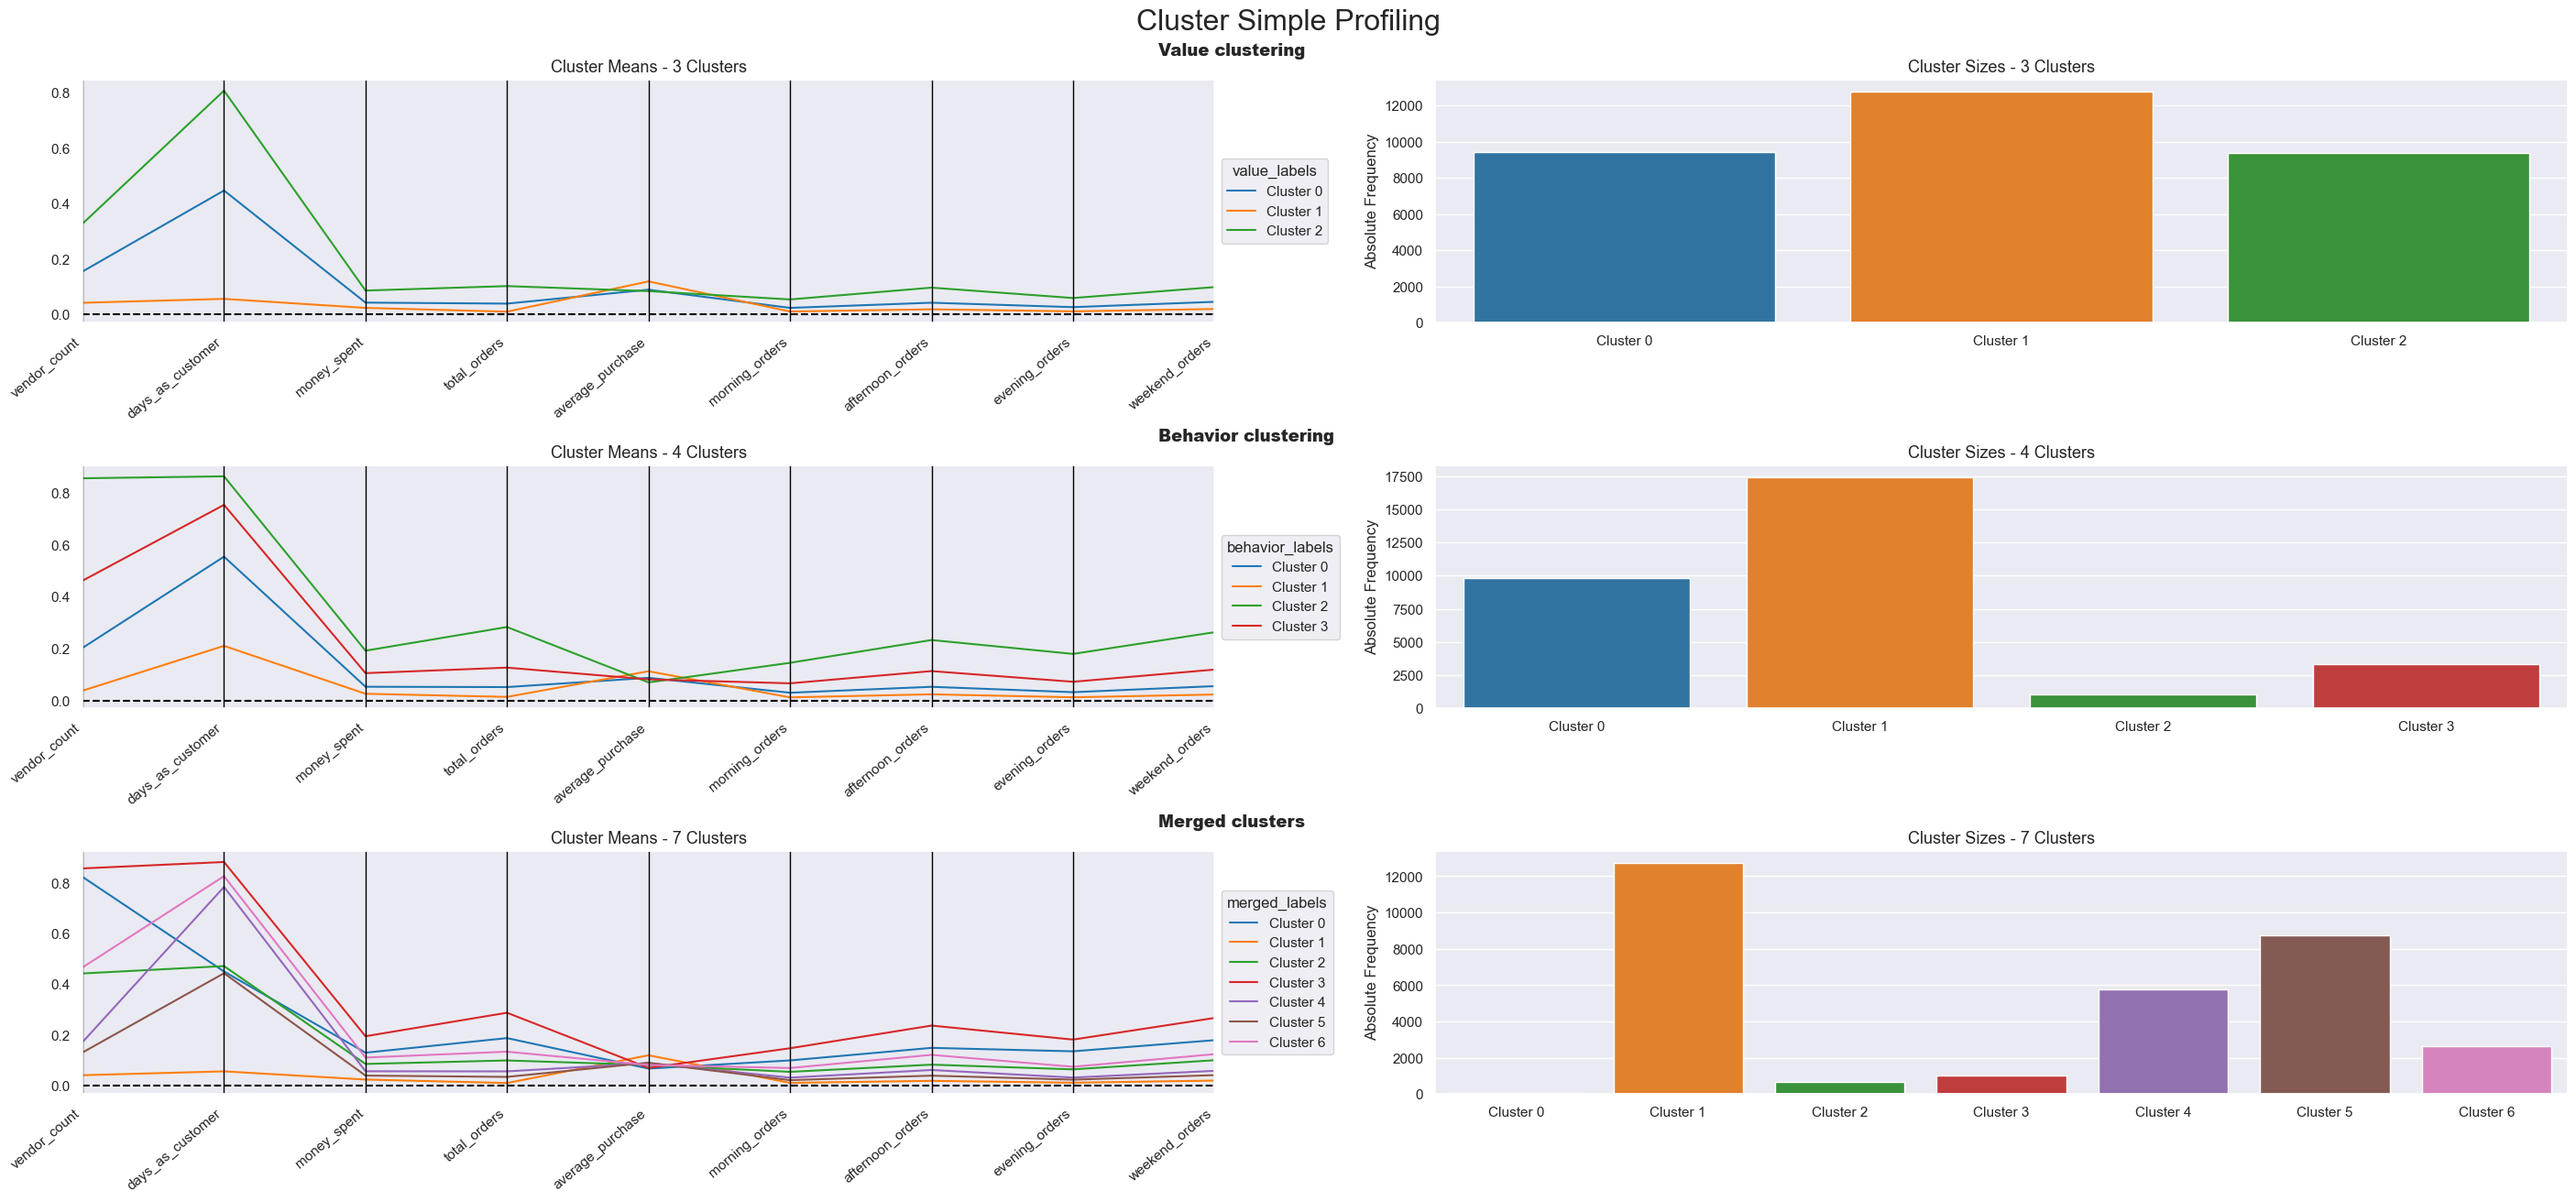

In [70]:
# Profilling each cluster (value, behavior, merged)
cluster_profiles(
    df = df[metric_features + ['value_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Behavior clustering", "Merged clusters"]
)

## Exercise: profiling with unused / categorical features

In [71]:
non_metric_features

['is_chain',
 'payment_method',
 'customer_city',
 'age_group',
 'customer_frequency',
 'customer_preference']

In [73]:
df_educ = df[[
    'merged_labels',
    'customer_preference',
    'customer_city',
    'age_group'
    ]].groupby(['merged_labels']).sum()

df_educ

,customer_preference,customer_city,age_group
merged_labels,,,
0,CUI_AmericanCUI_ChineseCUI_IndianCUI_AsianCUI_...,City ACity ACity ACity CCity CCity ACity CCity...,Young AdultYoung AdultYoung AdultYoung AdultYo...
1,CUI_IndianCUI_AmericanCUI_AmericanCUI_IndianCU...,City ACity CCity BCity BCity BCity CCity ACity...,Young AdultChildAdultYoung AdultYoung AdultAdu...
2,CUI_BeveragesCUI_ChineseCUI_JapaneseCUI_OTHERC...,City ACity ACity ACity ACity ACity ACity ACity...,Young AdultYoung AdultYoung AdultAdultYoung Ad...
3,CUI_AmericanCUI_AmericanCUI_AsianCUI_AsianCUI_...,City BCity ACity CCity CCity ACity ACity BCity...,Young AdultYoung AdultYoung AdultYoung AdultYo...
4,CUI_AsianCUI_JapaneseCUI_Street Food / SnacksC...,City CCity CCity CCity CCity BCity BCity BCity...,Young AdultAdultYoung AdultYoung AdultYoung Ad...
5,CUI_BeveragesCUI_DessertsCUI_ChineseCUI_Chicke...,City CCity ACity ACity ACity ACity BCity CCity...,Young AdultYoung AdultYoung AdultYoung AdultYo...
6,CUI_OTHERCUI_JapaneseCUI_AmericanCUI_JapaneseC...,City BCity ACity BCity ACity BCity BCity ACity...,Young AdultYoung AdultYoung AdultYoung AdultYo...


In [74]:
df[['merged_labels']].groupby(['merged_labels']).value_counts()

merged_labels
0       47
1    12754
2      685
3     1004
4     5759
5     8754
6     2628
Name: count, dtype: int64

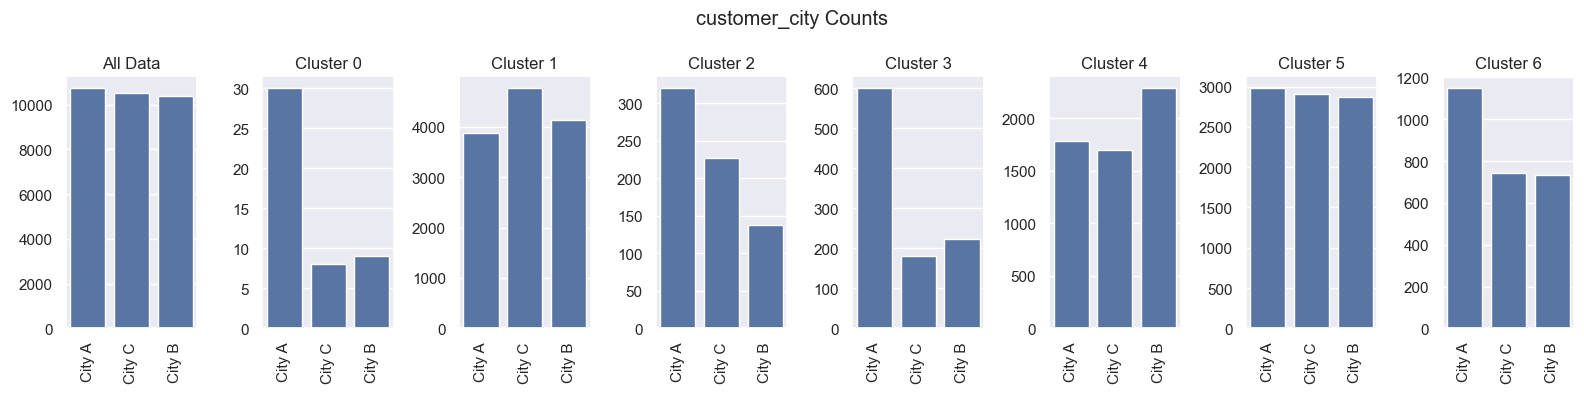

In [75]:
fig, axes = plt.subplots(1, 
                         df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16,4),
                         tight_layout=True,
                        #  sharey=True,
                         )


for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(df, 
                        x='customer_city', 
                        order = df['customer_city'].value_counts().index,
                        ax=ax)
        ax.set_title("All Data")
        
    else:    
        sns.countplot(df.loc[df['merged_labels']==i-1], 
                    x='customer_city', 
                    order = df['customer_city'].value_counts().index,
                    ax=ax)
        ax.set_title("Cluster {}".format(i-1))
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("customer_city Counts", )
plt.show()

In [76]:
merged_counts = df[['merged_labels']].groupby(['merged_labels']).value_counts()
merged_counts


merged_labels
0       47
1    12754
2      685
3     1004
4     5759
5     8754
6     2628
Name: count, dtype: int64

<Axes: xlabel='customer_city', ylabel='count'>

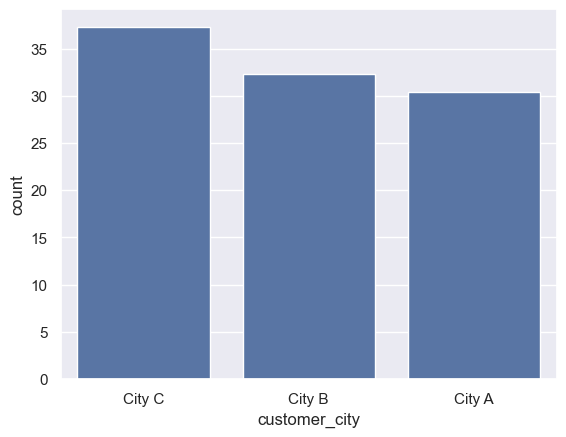

In [77]:
ci = 1
df_ci = df.loc[df['merged_labels']==ci, 'customer_city']

sns.barplot(100*df_ci.value_counts()/merged_counts[ci])


<Axes: xlabel='merged_labels'>

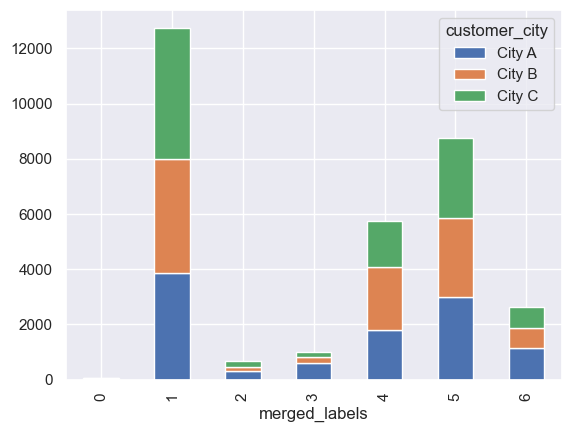

In [78]:
df_cl_ed = df.groupby([
    "merged_labels", 
    "customer_city",
    ])['customer_city'].size().unstack()

df_cl_ed


df_cl_ed.plot.bar(stacked=True)

<Axes: xlabel='merged_labels'>

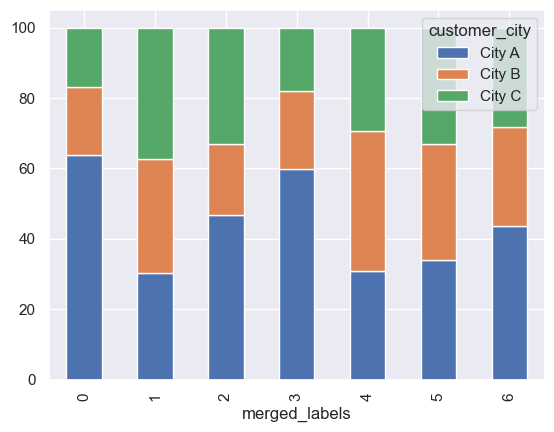

In [79]:
df_cl_ed_pct = df_cl_ed.copy()
for i in df['customer_city'].unique():
    df_cl_ed_pct[i] = 100*df_cl_ed_pct[i]/df['merged_labels'].value_counts().sort_index().values

df_cl_ed_pct.plot.bar(stacked=True)

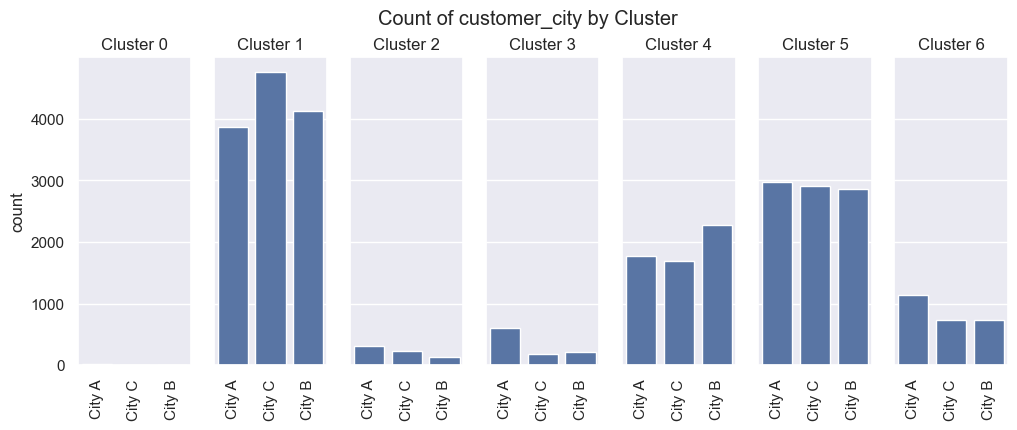

In [80]:
fig, axes = plt.subplots(1, df['merged_labels'].nunique(), 
                         figsize=(12,4),
                         sharey=True,)

for ax, clust in zip(axes.flatten(), range(df['merged_labels'].nunique())): 
    df_cl = df.loc[df['merged_labels']==clust]
    sns.countplot(df_cl, 
                  x='customer_city', 
                  order = df['customer_city'].value_counts().index,
                  ax=ax)
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")

    ax.set_title("Cluster {}".format(clust))
plt.suptitle("Count of customer_city by Cluster", y=1)
plt.show()

In [81]:
pd.crosstab(df["merged_labels"],df["customer_city"])

customer_city,City A,City B,City C
merged_labels,,,
0,30,9,8
1,3873,4123,4758
2,320,138,227
3,600,223,181
4,1780,2283,1696
5,2978,2869,2907
6,1148,735,745


### Exercise: What other visualizations from the EDA can you think of?

## Cluster visualization using t-SNE

In [82]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

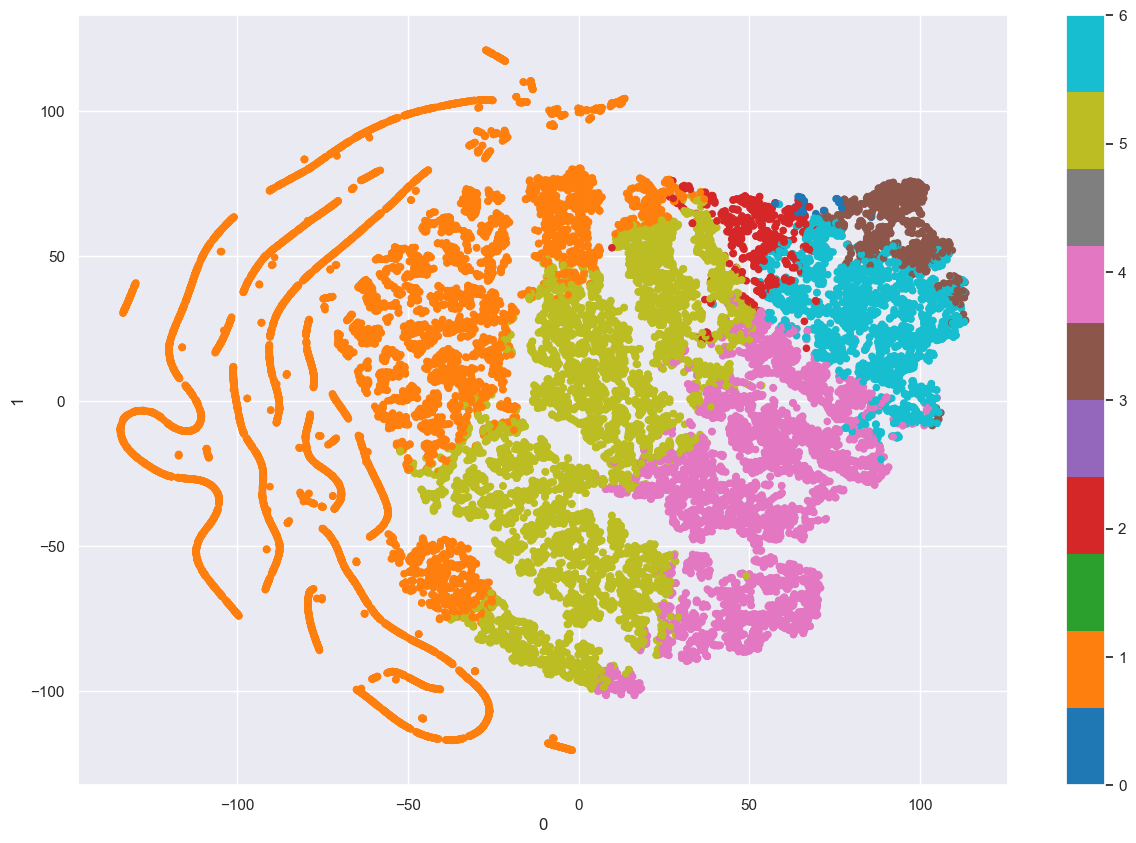

In [83]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Exercise: Improve T-SNE Visualization

### Exercise: Visualize using UMAP

### Exercise: Visualize using Principal Components


## Assess feature importance and reclassify outliers

### Using the R²
What proportion of each variables total SS is explained between clusters?

In [84]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [85]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

vendor_count        0.833726
days_as_customer    0.916226
money_spent         0.399091
total_orders        0.676079
average_purchase    0.044030
morning_orders      0.302143
afternoon_orders    0.378494
evening_orders      0.273785
weekend_orders      0.482397
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [86]:
# Preparing the data
X = df[metric_features]
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 95.21% of the customers correctly


In [87]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

days_as_customer    0.789024
vendor_count        0.210791
weekend_orders      0.000184
money_spent         0.000000
total_orders        0.000000
average_purchase    0.000000
morning_orders      0.000000
afternoon_orders    0.000000
evening_orders      0.000000
dtype: float64

In [88]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out[metric_features])
df_out.head()

NameError: name 'df_out' is not defined